# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [1]:
# ! pip install tensorflow<2.11 tensorflow-gpu<2.11 tensorflow-io matplotlib==3.7.* librosa scikit-learn pandas numpy ipykernel

## 1.2 Load Dependencies

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
from classify_utilities import AudioProcessor
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
import librosa
import numpy as np
import joblib
import random
from model import Deep_NN

In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


# 2. Preprocess the Data

## 2.1 Define Paths to Files

In [4]:
DATASET_DIR = 'dataset'
DATA_DIR = 'data'
TEST_DIR = 'test'
METADATA = "metadata.csv"
MODEL_PATH = os.path.join("model", "model.keras")
LABELER_PATH = os.path.join("model", "label_encoder.joblib")

# create folders if they don't exist
if not os.path.exists('model'):
    os.makedirs('model')
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('test'):
    os.makedirs('test')
if not os.path.exists('dataset'):
    os.makedirs('dataset')

In [5]:
AUDIO_CHUNK = 0.4 # seconds
SLICE_AUDIO = False

NUM_CHANNELS = 1
SAMPLE_RATE = 44100

N_FRAMES = None
N_MELS = 256
NFFT = 2048
FMAX = SAMPLE_RATE // 2
HOP_LENGTH = 512

EPOCHS = 10
BATCH_SIZE = 32

In [6]:
audio_processor = AudioProcessor(sample_rate=SAMPLE_RATE, 
                                 n_mels = N_MELS,
                                 fmax = FMAX,
                                 n_fft = NFFT,
                                 hop_length = HOP_LENGTH, 
                                 audio_chunk = AUDIO_CHUNK,
                                 slice_audio = SLICE_AUDIO
                                 )
                

## 2.2 Label Encoding

In [7]:
label_encoder = OneHotEncoder()

classes = os.listdir(DATASET_DIR)
classes.sort()
classes = np.array(classes).reshape(-1, 1)

try:
    label_encoder.fit(classes)
except IndexError:
    print("No classes found in dataset folder")

# Serialize and save the fitted encoder
joblib.dump(label_encoder, LABELER_PATH)

def idx2label(idx):
    idx_reshaped = np.array(idx).reshape(1, -1)
    return label_encoder.inverse_transform(idx_reshaped)[0][0]

def label2idx(label):
    label = np.array(label).reshape(-1, 1)
    return label_encoder.transform(label).toarray()[0]

In [8]:
random_label = random.choice(os.listdir(DATASET_DIR))
label2idx(random_label)

array([0., 1., 0.])

In [9]:
idx2label(label2idx(random_label))

'neg'

In [10]:
# External labeler
audio_processor.idx2label(label2idx(random_label), joblib.load(LABELER_PATH))

'neg'

## 2.3 Exploratory data analysis

### Produce metadata dataframe

In [11]:
# Analyze dataset:
# List all the files in dictionare and subdictionaries.
metadata = []

for root, _, files in os.walk(DATASET_DIR):
    for i, file in enumerate(files):
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            label = os.path.basename(root)
            class_ = label2idx(label)
            num_channels, sample_rate, bit_depth, avg_rms, length_in_seconds, length_in_frames = audio_processor.read_file_properties(filename)
            metadata.append({
                'filename': filename, 
                'label': label, 
                'class': class_,
                'num_channels': num_channels, 
                'sample_rate': sample_rate, 
                'bit_depth': bit_depth, 
                'avg_rms': avg_rms, 
                'length_in_seconds': length_in_seconds, 
                'length_in_frames': length_in_frames
            })

            print(f"Processing label: {label}, {i}th file named: {file}")
        else:
            print(f"Skipped {i} file. {file}")
            
metadata = pd.DataFrame(metadata)
metadata.to_csv(METADATA, index=False)

Processing label: cheers, 0th file named: cheers2_h_0001.wav
Processing label: cheers, 1th file named: cheers2_h_0002.wav
Processing label: cheers, 2th file named: cheers2_h_0003.wav
Processing label: cheers, 3th file named: cheers2_h_0004.wav
Processing label: cheers, 4th file named: cheers2_h_0005.wav
Processing label: cheers, 5th file named: cheers2_h_0006.wav
Processing label: cheers, 6th file named: cheers2_h_0007.wav
Processing label: cheers, 7th file named: cheers2_h_0008.wav
Processing label: cheers, 8th file named: cheers2_h_0009.wav
Processing label: cheers, 9th file named: cheers2_h_0010.wav
Processing label: cheers, 10th file named: cheers2_h_0011.wav
Processing label: cheers, 11th file named: cheers2_h_0012.wav
Processing label: cheers, 12th file named: cheers2_h_0013.wav
Processing label: cheers, 13th file named: cheers2_h_0014.wav
Processing label: cheers, 14th file named: cheers2_h_0015.wav
Processing label: cheers, 15th file named: cheers2_h_0016.wav
Processing label: 

### Observe the data

In [12]:
metadata.head()

,filename,label,class,num_channels,sample_rate,bit_depth,avg_rms,length_in_seconds,length_in_frames
0,dataset\cheers\cheers2_h_0001.wav,cheers,"[1.0, 0.0, 0.0]",1,44100,16,0.007223,0.397642,17536
1,dataset\cheers\cheers2_h_0002.wav,cheers,"[1.0, 0.0, 0.0]",1,44100,16,0.004736,0.397642,17536
2,dataset\cheers\cheers2_h_0003.wav,cheers,"[1.0, 0.0, 0.0]",1,44100,16,0.004771,0.397642,17536
3,dataset\cheers\cheers2_h_0004.wav,cheers,"[1.0, 0.0, 0.0]",1,44100,16,0.006177,0.397642,17536
4,dataset\cheers\cheers2_h_0005.wav,cheers,"[1.0, 0.0, 0.0]",1,44100,16,0.004919,0.397642,17536


### class balance

In [13]:
print(metadata["label"].value_counts())

label
cheers     778
neg        699
silence    476
Name: count, dtype: int64


### plot class waveforms

dataset\cheers\cheers2_h_0001.wav
dataset\neg\neg_cheers_0001.wav
dataset\silence\ambient_0001.wav


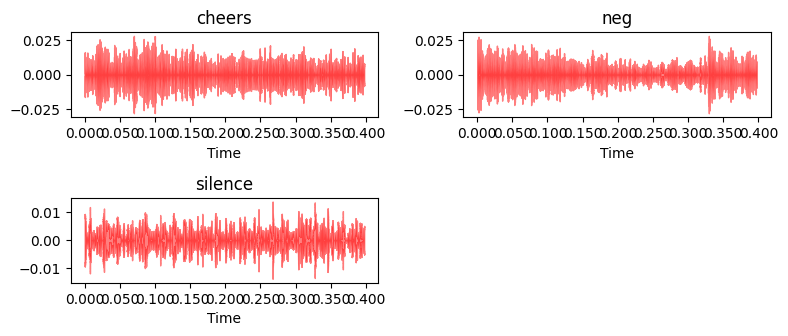

In [14]:
labels = metadata["label"].unique()

fig = plt.figure(figsize=(8,8))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    filtered_df = metadata[metadata["label"] == label]
    slice_file_name = filtered_df["filename"].iloc[0]
    fold = filtered_df["label"].iloc[0]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sr = librosa.load(os.path.join(slice_file_name), sr=SAMPLE_RATE, mono=False)
    librosa.display.waveshow(y = data, sr=sr, color="r", alpha=0.5, label='Harmonic')
    print(slice_file_name)
     
plt.tight_layout()  # This will adjust spacing between subplots to prevent overlap
plt.show()  # This will display the plot

In [15]:
# num of channels 
print("Channels: ")
print(metadata.num_channels.value_counts(normalize=True))
print("\n")

# sample rates 
print("Sample Rates: ")
print(metadata.sample_rate.value_counts(normalize=True))
print("\n")

# bit depth
print("Bit Depth: ")
print(metadata.bit_depth.value_counts(normalize=True))
print("\n")

# length in samples
print("Samples: ")
print(metadata.length_in_frames.describe())
print("\n")

# length in seconds
print("Length (s): ")
print(metadata.length_in_seconds.describe())

# RMS
print(metadata.avg_rms.describe())


Channels: 
num_channels
1    1.0
Name: proportion, dtype: float64


Sample Rates: 
sample_rate
44100    1.0
Name: proportion, dtype: float64


Bit Depth: 
bit_depth
16    1.0
Name: proportion, dtype: float64


Samples: 
count     1953.0
mean     17536.0
std          0.0
min      17536.0
25%      17536.0
50%      17536.0
75%      17536.0
max      17536.0
Name: length_in_frames, dtype: float64


Length (s): 
count    1953.000000
mean        0.397642
std         0.000000
min         0.397642
25%         0.397642
50%         0.397642
75%         0.397642
max         0.397642
Name: length_in_seconds, dtype: float64
count    1953.000000
mean        0.007160
std         0.005720
min         0.001063
25%         0.003429
50%         0.005982
75%         0.008665
max         0.087360
Name: avg_rms, dtype: float64


## 2.4 Audio Preprocessing:

### Test audio preprocessing methods
-   Librosa -> 
        SR: 22050
        channel: 1
    trim/pad ->
        length: 3s (3x22050)
    spectrogram ->
        mel-spectrogram / spectrogram / MFCC
    post-process ->
        to Db (log scale, more apparent patterns)
        abs 
    normalize ->
        
        


audio_file shape (17536,) - (frames, channels)
audio_file sample rate 44100 Hz
Spectrogram shape (256, 35) - (mels/frequency, frames/time)
spectrogram min: 0.0 spectrogram max: 1.0, average: 0.4646384119987488
spectrogram dtype: float32
audio dtype: float32 - bit depth


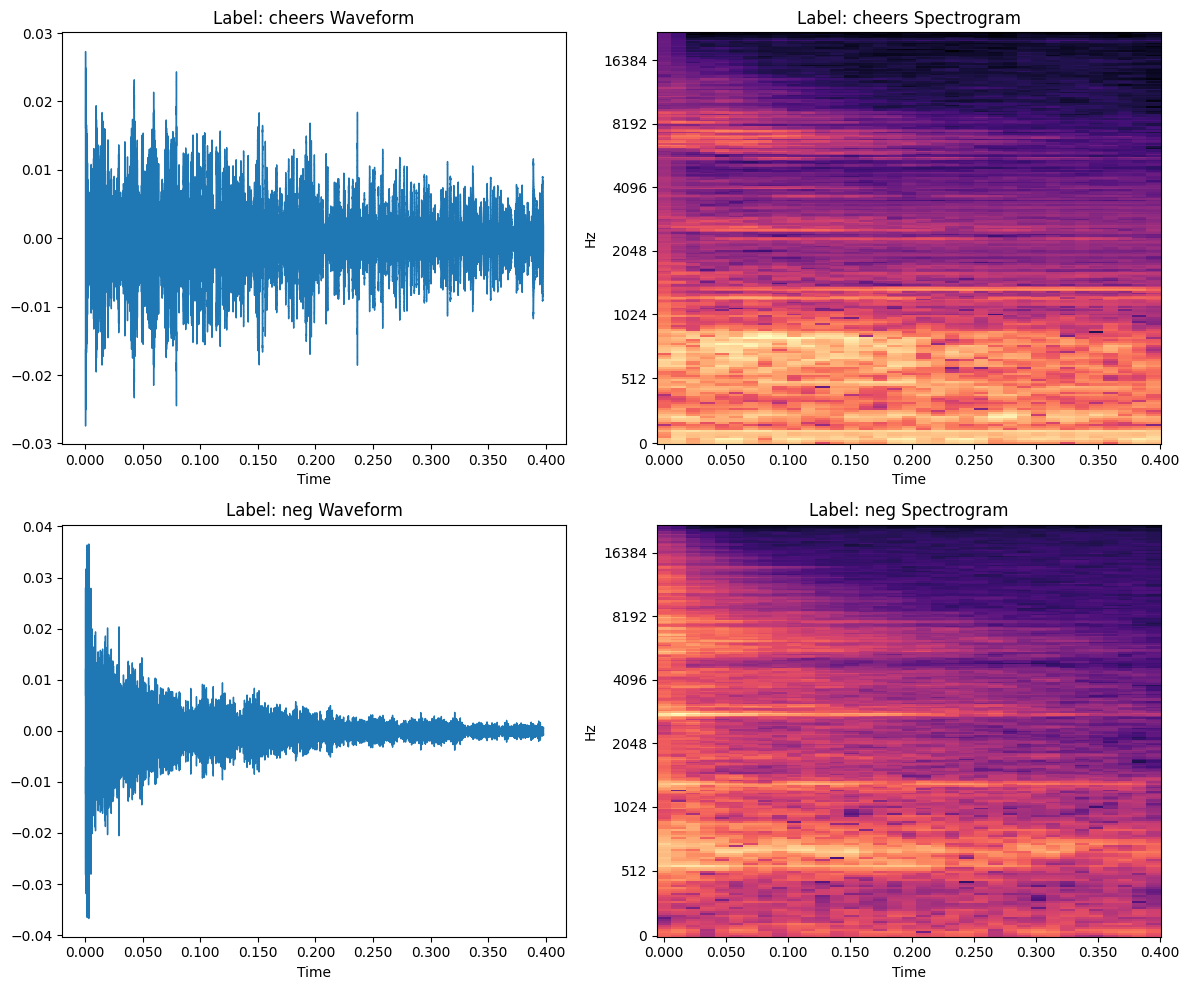

In [16]:
# Test the Fourier transform
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
rows = metadata.iloc[[34, 1280]]

#rows = metadata.sample(2)
slice_length = AUDIO_CHUNK
samples_show = len(rows)
pass_ = 0

fig, axes = plt.subplots(nrows=samples_show, ncols=2, figsize=(12, samples_show* 5))

for i, row in rows.iterrows():    
    if pass_ > samples_show:
        break
    audio_file, librosa_sample_rate = librosa.load(row["filename"], sr=SAMPLE_RATE)
    if SLICE_AUDIO: 
        print(slice)
        sample_length = slice_length * librosa_sample_rate

        audio_file = audio_file[:sample_length]
        if len(audio_file) < sample_length:
            audio_file = np.pad(audio_file, (0, sample_length - len(audio_file)), constant_values=0)

    #spectrogram = audio_processor(data = audio_file)
    spectrogram = librosa.feature.melspectrogram(y=audio_file, sr=librosa_sample_rate, n_mels=256, fmax = FMAX, n_fft=2048, hop_length=512)
    spectrogram = (librosa.power_to_db(spectrogram, ref=np.max))

    # general scale normalization with min-max
    #min_db, max_db = -60, 80
    #spectrogram = np.clip((spectrogram - min_db) / (max_db - min_db), 0, 1)
    #spectrogram = (spectrogram - min_db) / (max_db - min_db)

    # Min-Max normalization
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())

        # wave Plot
    axes[pass_, 0].set_title(f"Label: {row['label']} Waveform")
    librosa.display.waveshow(audio_file, sr=librosa_sample_rate, ax=axes[pass_, 0])
    # spectrogram plot
    axes[pass_, 1].set_title(f"Label: {row['label']} Spectrogram")
    img = librosa.display.specshow(spectrogram, sr=librosa_sample_rate, x_axis='time', y_axis='mel', ax=axes[pass_, 1])
    pass_ += 1


print(f"audio_file shape {audio_file.shape} - (frames, channels)")
print(f"audio_file sample rate {librosa_sample_rate} Hz")
print(f"Spectrogram shape {spectrogram.shape} - (mels/frequency, frames/time)")
print(f"spectrogram min: {spectrogram.min()} spectrogram max: {spectrogram.max()}, average: {spectrogram.mean()}")
print(f"spectrogram dtype: {spectrogram.dtype}")
print(f"audio dtype: {audio_file.dtype} - bit depth")

#fig.colorbar(img, ax=axes[:, 0], format='%+2.0f dB')
plt.tight_layout()
plt.show()

### Preprocessing function

In [17]:
def extract_features(row):
    
    class_label = row["class"]
    
    audio_file,_ = librosa.load(row["filename"], sr=SAMPLE_RATE)

    spectrogram = audio_processor(
        data = audio_file)
    
    shape = spectrogram.shape

    return spectrogram, class_label, shape

## 3 Produce Dataset

## 3.1 Extract features and labels into dataframe

In [18]:
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
features = []

for index, row in metadata.iterrows():
    features.append(extract_features(row))
    print(f"Processed {index} file. {row['filename']}")

   
dataset_df = pd.DataFrame(features, columns=["features", "class_label", "shape"])
print('Finished feature extraction from ', len(dataset_df), ' files') 
N_FRAMES = dataset_df["shape"].iloc[0][0]
print(f"Number of frames: {N_FRAMES}")

Processed 0 file. dataset\cheers\cheers2_h_0001.wav
Processed 1 file. dataset\cheers\cheers2_h_0002.wav
Processed 2 file. dataset\cheers\cheers2_h_0003.wav
Processed 3 file. dataset\cheers\cheers2_h_0004.wav
Processed 4 file. dataset\cheers\cheers2_h_0005.wav
Processed 5 file. dataset\cheers\cheers2_h_0006.wav
Processed 6 file. dataset\cheers\cheers2_h_0007.wav
Processed 7 file. dataset\cheers\cheers2_h_0008.wav
Processed 8 file. dataset\cheers\cheers2_h_0009.wav
Processed 9 file. dataset\cheers\cheers2_h_0010.wav
Processed 10 file. dataset\cheers\cheers2_h_0011.wav
Processed 11 file. dataset\cheers\cheers2_h_0012.wav
Processed 12 file. dataset\cheers\cheers2_h_0013.wav
Processed 13 file. dataset\cheers\cheers2_h_0014.wav
Processed 14 file. dataset\cheers\cheers2_h_0015.wav
Processed 15 file. dataset\cheers\cheers2_h_0016.wav
Processed 16 file. dataset\cheers\cheers2_h_0017.wav
Processed 17 file. dataset\cheers\cheers2_h_0018.wav
Processed 18 file. dataset\cheers\cheers2_h_0019.wav
Pro

In [19]:
dataset_df.head()

,features,class_label,shape
0,"[[0.6602947, 0.65748537, 0.66606164, 0.7451419...","[1.0, 0.0, 0.0]","(35, 256)"
1,"[[0.7874459, 0.7809191, 0.78227663, 0.66924286...","[1.0, 0.0, 0.0]","(35, 256)"
2,"[[0.86734694, 0.8705438, 0.88854945, 0.8533904...","[1.0, 0.0, 0.0]","(35, 256)"
3,"[[0.72787017, 0.74772775, 0.7844977, 0.7966794...","[1.0, 0.0, 0.0]","(35, 256)"
4,"[[0.68613404, 0.6960409, 0.72391707, 0.6502508...","[1.0, 0.0, 0.0]","(35, 256)"


In [20]:
dataset_df["shape"].value_counts()

shape
(35, 256)    1953
Name: count, dtype: int64

## 3.2 Train Test Split

In [21]:
X = np.array(dataset_df.features.tolist())
y = np.array(dataset_df.class_label.tolist())
X.shape

(1953, 35, 256)

In [22]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 42)

### Double check prepared dataset

In [23]:
print(f"randomm feature example: {X[0]} and label: {y[0]}")

randomm feature example: [[0.6602947  0.65748537 0.66606164 ... 0.20181347 0.21095362 0.20682672]
 [0.81573945 0.82920927 0.8600057  ... 0.14615177 0.1395921  0.13809693]
 [0.87349856 0.88805264 0.91991585 ... 0.06955229 0.02386156 0.04808927]
 ...
 [0.7467799  0.72239405 0.6365414  ... 0.04769301 0.03351765 0.03567833]
 [0.7992437  0.80977076 0.8374726  ... 0.08329545 0.05266722 0.05089511]
 [0.79017323 0.80179024 0.8306739  ... 0.12217566 0.10598437 0.11073159]] and label: [1. 0. 0.]


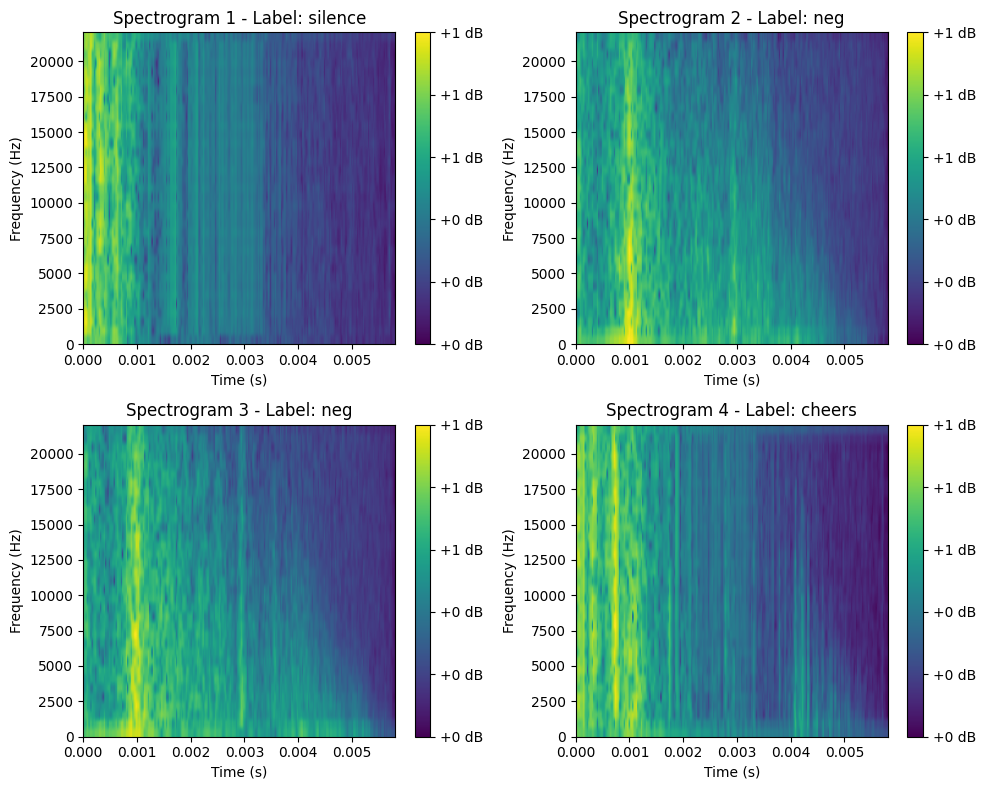

In [24]:
selected_rows = dataset_df.sample(n=4)

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Iterate over the subplots and fill each with a spectrogram
for i, (idx, row) in enumerate(selected_rows.iterrows()):
    spectrogram = row['features']
    label = row['class_label']
    ax = axs[i // 2, i % 2]  # Calculate the subplot position
    im = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis',
                   extent=[0, spectrogram.shape[1] / SAMPLE_RATE, 0, SAMPLE_RATE / 2])
    ax.set_title(f'Spectrogram {i+1} - Label: {idx2label(label)}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(im, ax=ax, format='%+2.0f dB')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

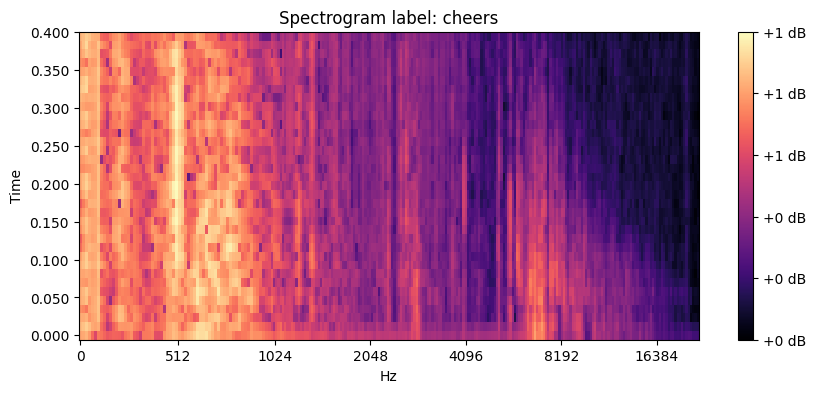

In [25]:
# Get the random feature array
sample_no = 42
sample_f = dataset_df.iloc[sample_no]["features"]
sample_l = dataset_df.iloc[sample_no]["class_label"]
# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(sample_f, sr=SAMPLE_RATE, x_axis='mel', y_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram label: ' + idx2label(sample_l))
plt.show()

## 3.3 Reshape sets for NN input layer

In [68]:
x_train = x_train.reshape(x_train.shape[0], N_FRAMES, N_MELS, NUM_CHANNELS)
x_test = x_test.reshape(x_test.shape[0], N_FRAMES, N_MELS, NUM_CHANNELS)

num_labels = y.shape[1]
print(f"num_labels: {num_labels}")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

num_labels: 3
x_train shape: (1562, 35, 256, 1)
y_train shape: (1562, 3)


# 4. Build Deep Learning Model

## 4.1 Load deep neural net

In [69]:
# load a class with various model archietectures to test
modelClass = Deep_NN(num_classes=num_labels, dim1 = N_FRAMES, dim2 = N_MELS, dim3 = NUM_CHANNELS)

In [70]:
# Choose model architecture to train on
model = modelClass.defaultCNN()
#model = modelClass.customCNN1()

#model = modelClass.mobilenetv3_nn() 
#model = modelClass.inresv2_nn() # Input at leaset 75x75
#model = modelClass.effnetv2_nn()
#model = modelClass.exception_nn() # Input at leaset 71x71

## 4.2 Compile Sequential Model

In [71]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [81]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=optimizer, 
    loss='CategoricalCrossentropy', 
    metrics=['accuracy', Precision(), Recall()]
    )

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 33, 254, 16)       160       
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 252, 16)       2320      
                                                                 
 flatten_3 (Flatten)         (None, 124992)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               15999104  
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 16,001,971
Trainable params: 16,001,971
Non-trainable params: 0
_________________________________________________________________


## 4.3 Fit Model, View Loss and KPI Plots

In [83]:
hist = model.fit(x_train, 
                 y_train, 
                 epochs=EPOCHS, 
                 validation_data=(x_test, y_test), 
                 batch_size=BATCH_SIZE
                 )

Epoch 1/10


49/49 [==============================] - 11s 213ms/step - loss: 2.2798e-04 - accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - val_loss: 0.0333 - val_accuracy: 0.9923 - val_precision_9: 0.9923 - val_recall_9: 0.9923
Epoch 2/10
49/49 [==============================] - 10s 206ms/step - loss: 2.9033e-04 - accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - val_loss: 0.0483 - val_accuracy: 0.9923 - val_precision_9: 0.9923 - val_recall_9: 0.9923
Epoch 3/10
49/49 [==============================] - 10s 203ms/step - loss: 1.5736e-04 - accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - val_loss: 0.0328 - val_accuracy: 0.9923 - val_precision_9: 0.9923 - val_recall_9: 0.9923
Epoch 4/10
49/49 [==============================] - 10s 206ms/step - loss: 1.2804e-04 - accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9923 - val_precision_9: 0.9923 - val_recall_9: 0.9923
Epoch 5/10
49/49 [==============================] - 10s 206ms/s

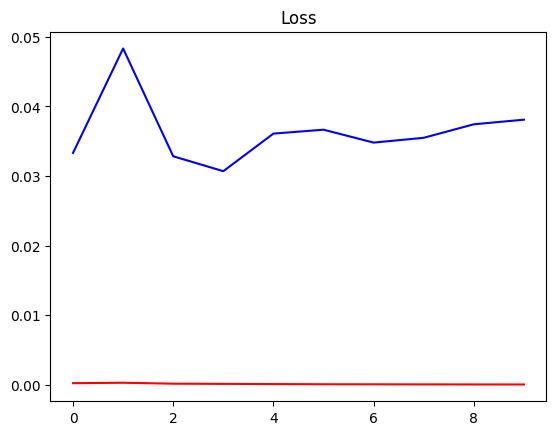

In [84]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

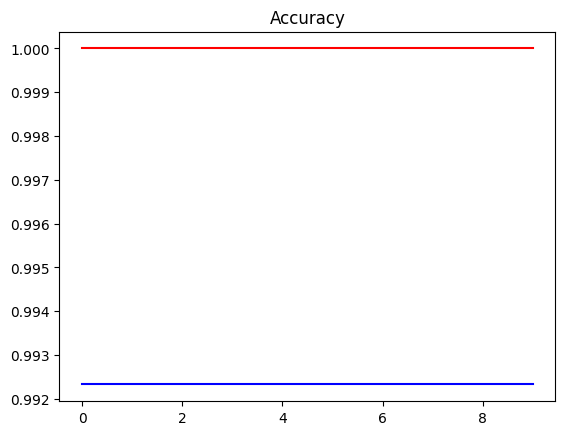

In [85]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

KeyError: 'precision'

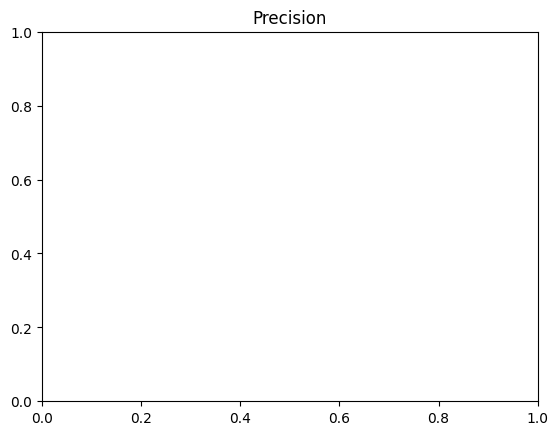

In [86]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

KeyError: 'recall'

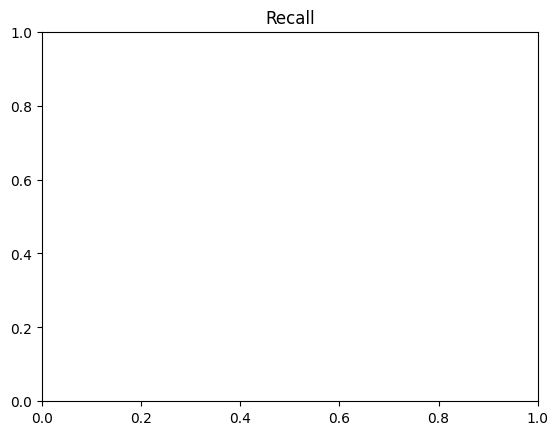

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 5. Make a Prediction on a Single Clip

## 5.1 Make a Prediction, Evaluate

In [87]:
predictions = model.predict(x_test)

13/13 [==============================] - 0s 24ms/step


In [88]:
print(idx2label(predictions[19]))
print(idx2label(y_test[19]))
print(f"input default shape: {x_test[1].shape}")
print(f"reshaped input feature shape: {np.expand_dims((x_test[21]), axis=0).shape}")

cheers
cheers
input default shape: (35, 256, 1)
reshaped input feature shape: (1, 35, 256, 1)


In [89]:
prediction = model.predict(np.expand_dims((x_test[1]), axis=0))
print(prediction)
print(idx2label(prediction))

1/1 [==============================] - 0s 62ms/step
[[4.168609e-10 1.000000e+00 7.326302e-14]]
neg


In [90]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

49/49 [==============================] - 1s 26ms/step - loss: 3.7484e-05 - accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000
Training Accuracy:  1.0
13/13 [==============================] - 0s 23ms/step - loss: 0.0381 - accuracy: 0.9923 - precision_9: 0.9923 - recall_9: 0.9923
Testing Accuracy:  0.9923273921012878


13/13 [==============================] - 0s 24ms/step - loss: 0.0381 - accuracy: 0.9923 - precision_9: 0.9923 - recall_9: 0.9923


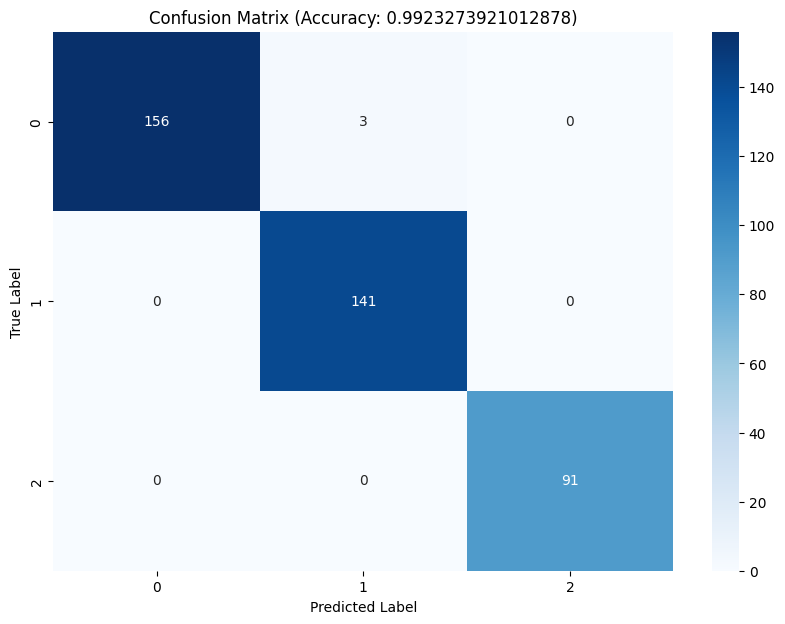

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'predictions' is an array of predicted probabilities for each class
# And 'y_test' is an array of actual class labels

# Convert predicted probabilities to class labels
predicted_labels = [idx2label(pred) for pred in predictions]
y_test_labels = [idx2label(pred) for pred in y_test]

# Create the confusion matrix
cm = confusion_matrix(y_test_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
score = model.evaluate(x_test, y_test, verbose=1)

plt.title(f"Confusion Matrix (Accuracy: {score[1]})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 5.2 Save Model

In [92]:
model.save(MODEL_PATH)

# 6. Inference 

## 6.1 Load local model and labels

In [93]:
# Load the encoder in the inference environment
loaded_encoder = joblib.load(LABELER_PATH)
model = tf.keras.models.load_model(MODEL_PATH)

## 6.1 Inference on loacl files

In [94]:
audio_files = os.listdir(TEST_DIR)
random.shuffle(audio_files)

try:
    print(audio_files[1])
    audio_labels = [os.path.splitext(file)[0] for file in audio_files]
except IndexError:
    print("No files in test directory")

No files in test directory


In [95]:
for file in audio_files:
    path = os.path.join(TEST_DIR, file)
    print(path)
    data, _ = librosa.load(path, sr=SAMPLE_RATE)
    prediction_feature = audio_processor(
            data = data
        )
    
    # Reshape to match model input shape
    prediction_feature = prediction_feature.reshape(1, N_FRAMES, N_MELS, NUM_CHANNELS)
    predicted_class = idx2label(model.predict(prediction_feature)) 
    print("The predicted class is:", predicted_class, '\n') 

## 6.2 Real-time inference

## run "run.py"

In [96]:
from inference_class import SoundClassificationService

def main():

    config = {
        "model_path": MODEL_PATH,
        "labels_path": LABELER_PATH,
        
        "sample_rate": SAMPLE_RATE,
        "num_channels": NUM_CHANNELS,
        "audio_chunk": AUDIO_CHUNK,
        
        "num_mels": N_MELS,
        "n_fft": NFFT,
        "fmax": FMAX,
        "hop_length": HOP_LENGTH,
        
        "confidence_threshold": 0.5,
        "listening_hop_length": 0.6,
        "device": "cpu"

    }

    service = SoundClassificationService.get_instance(config)
    service.listen_and_predict(duration=AUDIO_CHUNK, overlap=0.5)


if __name__ == "__main__":
    main()

Listening... Press Ctrl+C to stop.


ValueError: could not broadcast input array from shape (22050,) into shape (17640,)